In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Activation,Layer,Lambda
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend
from keras.optimizers import Adam
from sklearn.metrics import r2_score

## __1 - Business Problem__  
___Prepare a model for strength of concrete data using Neural Networks___  

## __2 - Data collection and description__ 

In [2]:
df = pd.read_csv("concrete.csv")

In [3]:
df1 = df.copy()

In [4]:
df1

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,270,55.06


In [5]:
df1.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [6]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


### Outlier Check

C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


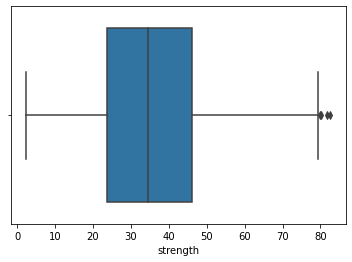

In [7]:
ax = sns.boxplot(df1['strength'])

### There are 3 Outlier instances in our data

In [8]:
plt.rcParams["figure.figsize"] = 9,5

Skew: 0.41697728841071807
Kurtosis: -0.3137248604469969


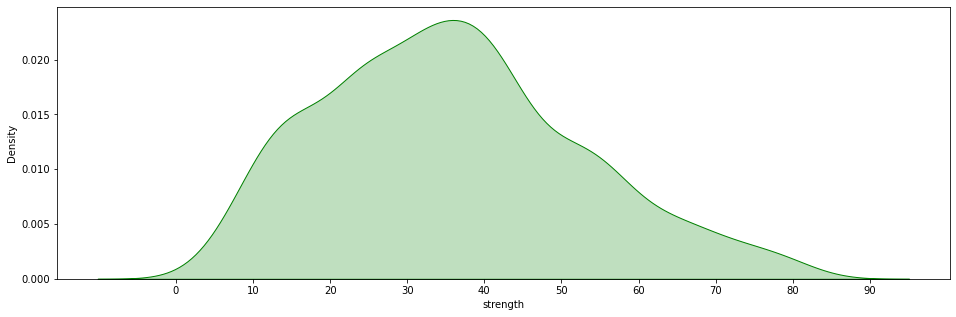

In [9]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df1['strength'].skew()))
print("Kurtosis: {}".format(df1['strength'].kurtosis()))
ax = sns.kdeplot(df1['strength'],shade=True,color='g')
plt.xticks([i for i in range(0,100,10)])
plt.show()

### The Data is positively skewed and has negative kurtosis value  
### Majority of the cement has maximum strengt between 20 and 60

In [11]:
num_columns = df1.select_dtypes(exclude='object').columns.tolist()

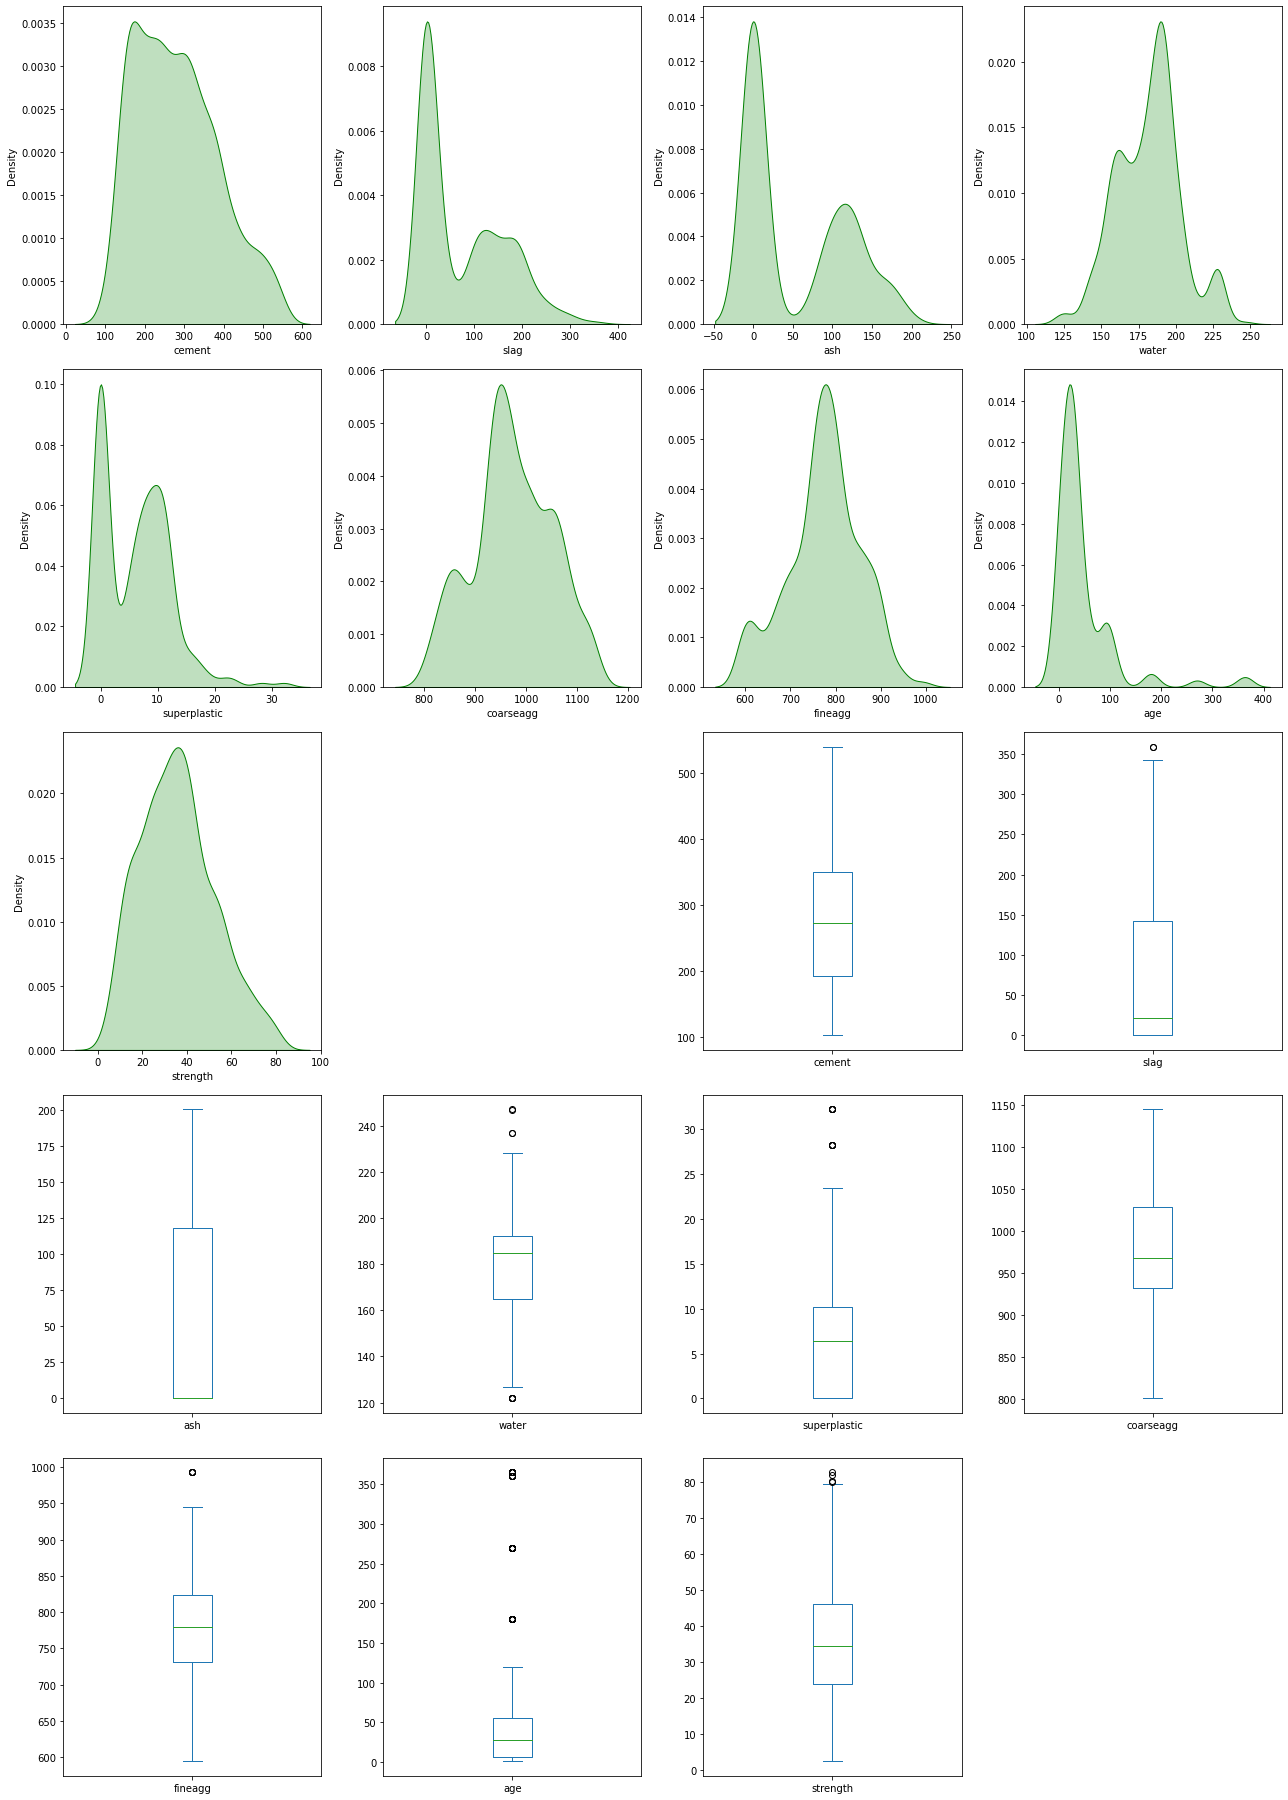

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
skewness,0.509481,0.800717,0.537354,0.074628,0.907203,-0.040220,-0.253010,3.269177,0.416977
kurtosis,-0.520652,-0.508175,-1.328746,0.122082,1.411269,-0.599016,-0.102177,12.168989,-0.313725


In [12]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

### Finding Correlation

In [13]:
corr = df1.corr()

<AxesSubplot:>

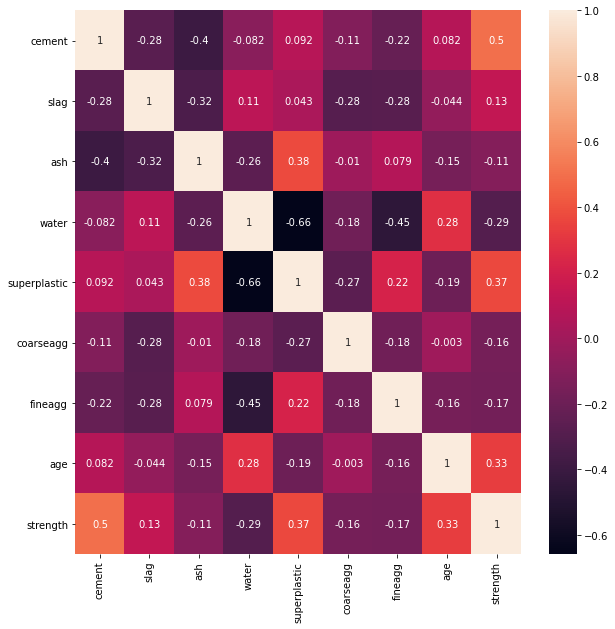

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True)

## __3 - Neural Network Model__ 

In [15]:
X = df1.iloc[:,0:8]
y = df1.iloc[:,8]

In [16]:
x_train,x_test,y_train,y_test= train_test_split(X,y, test_size=0.3)

In [17]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [18]:
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [19]:
model=Sequential()

In [22]:
model.add(Dense(64,input_dim=8,activation = 'relu'))
model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1,activation='linear'))

In [23]:
opt = Adam(lr=0.0015)

C:\Users\LENOVO\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
model.compile(optimizer=opt,loss='mean_squared_error',metrics=[rmse])

In [29]:
history = model.fit(x_train,y_train,epochs = 35 ,batch_size=32,validation_split=0.1)

Epoch 1/35
21/21 [==============================] - 2s 17ms/step - loss: 1479.2645 - rmse: 35.2781 - val_loss: 1622.0730 - val_rmse: 36.3956
Epoch 2/35
21/21 [==============================] - 0s 5ms/step - loss: 1411.5835 - rmse: 34.9922 - val_loss: 1562.6761 - val_rmse: 35.8932
Epoch 3/35
21/21 [==============================] - 0s 5ms/step - loss: 1353.4680 - rmse: 34.6177 - val_loss: 1528.9397 - val_rmse: 35.7283
Epoch 4/35
21/21 [==============================] - 0s 4ms/step - loss: 1285.7714 - rmse: 34.1296 - val_loss: 1495.1434 - val_rmse: 35.5691
Epoch 5/35
21/21 [==============================] - 0s 5ms/step - loss: 1217.6980 - rmse: 33.5282 - val_loss: 1409.6414 - val_rmse: 34.7294
Epoch 6/35
21/21 [==============================] - 0s 4ms/step - loss: 1150.7626 - rmse: 32.8106 - val_loss: 1342.9052 - val_rmse: 34.0640
Epoch 7/35
21/21 [==============================] - 0s 5ms/step - loss: 1077.3269 - rmse: 31.9847 - val_loss: 1245.5516 - val_rmse: 32.9941
Epoch 8/35
21/21 [=

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                        

## __4 - Conclusion__ 

In [31]:
y_predict = model.predict(x_test)

10/10 [==============================] - 0s 3ms/step


In [32]:
r2_score(y_test,y_predict)

0.8796031447601065

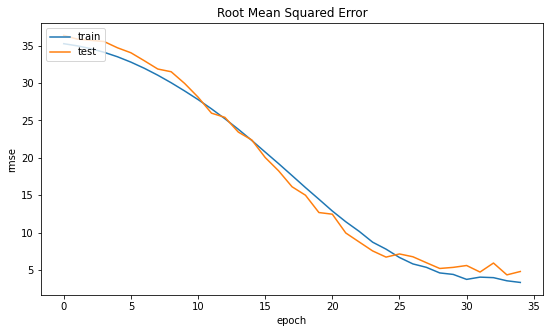

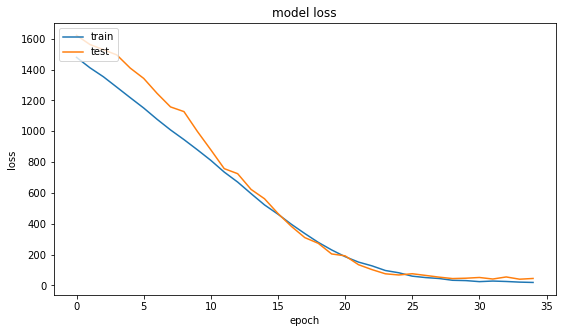

In [33]:
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Root Mean Squared Error')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('4.png')
plt.show()

### The model has an acceptable score